In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from sklearn.model_selection import train_test_split
import statsmodels as sms
mpl.rc('figure', max_open_warning = 0)

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/data_stage.csv')
#data=data.set_index('Date',drop=True)
data.Date[0]

'2022-04-29 15:00:00'

In [ ]:

data=data.sort_values(by=['Code_ATM','Date'])
for i in range(len(data)):
  data.Date[i] = datetime.datetime.strptime(data.Date[i],"%Y-%m-%d %H:%M:%S")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
data=data.reset_index(drop=True)
#adding a column with only the day to make a groupby day
codes=data['Code_ATM'].unique()
l=[]
for i in range(len(codes)):
  l.append((data[data['Code_ATM']==codes[i]].drop(columns=['Code_ATM']),codes[i]))
l1=[]
for i in range(len(l)):
  l1.append((l[i][0].reset_index(drop=True),codes[i]))
  for j in range(len(l1[i][0])):
    l1[i][0]['Date'][j]=l1[i][0]['Date'][j].date()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
#this takes up alot of memory space so execute only if you need it
#for i in range (len(codes)):
  #l[i][0].plot(y='Montant' ,figsize=(150,15))
#to make this cell work make the date column the index one

In [ ]:
l[0][0]

,Date,Montant,Nombre,working,religious,holiday_sequence,school
0,2022-01-01 02:00:00,100,1,0,0,"(0, 0, 0)",0
1,2022-01-01 06:00:00,400,1,0,0,"(0, 0, 0)",0
2,2022-01-01 07:00:00,100,1,0,0,"(0, 0, 0)",0
3,2022-01-01 08:00:00,100,1,0,0,"(0, 0, 0)",0
4,2022-01-01 09:00:00,300,1,0,0,"(0, 0, 0)",0
...,...,...,...,...,...,...,...
2810,2022-07-18 09:00:00,1140,9,1,0,"(0, 1, 1)",0
2811,2022-07-18 10:00:00,100,1,1,0,"(0, 1, 1)",0
2812,2022-07-18 11:00:00,410,4,1,0,"(0, 1, 1)",0
2813,2022-07-18 12:00:00,1160,10,1,0,"(0, 1, 1)",0


In [ ]:
df=l[0][0].drop('holiday_sequence',axis=1)

In [ ]:
df.set_index('Date',inplace=True)

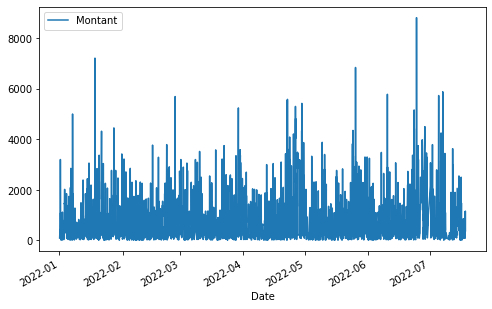

In [ ]:
df.plot(y='Montant',figsize=(8,5))

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df_sc=scaler.fit_transform(np.array(df).reshape(-1,1))
df

,Montant,Nombre,working,religious,school
Date,,,,,
2022-01-01 02:00:00,100,1,0,0,0
2022-01-01 06:00:00,400,1,0,0,0
2022-01-01 07:00:00,100,1,0,0,0
2022-01-01 08:00:00,100,1,0,0,0
2022-01-01 09:00:00,300,1,0,0,0
...,...,...,...,...,...
2022-07-18 09:00:00,1140,9,1,0,0
2022-07-18 10:00:00,100,1,1,0,0
2022-07-18 11:00:00,410,4,1,0,0


In [ ]:
training_size=int(len(df_sc)*0.7)
val_size=int(len(df_sc)*0.15)
test_size=len(df_sc)-training_size-val_size
train_data,val_data,test_data=df_sc[0:training_size],df_sc[training_size:training_size+val_size],df_sc[training_size+val_size:len(df_sc)]

In [ ]:
print(train_data)

[[0.01135074]
 [0.00011351]
 [0.        ]
 ...
 [0.00011351]
 [0.08059024]
 [0.00068104]]


In [ ]:
training_size,val_size,test_size

(9852, 2111, 2112)

In [ ]:
#prep the lstm model
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]    
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)
X_val, yval = create_dataset(val_data, time_step)

In [ ]:
print(X_train.shape), print(y_train.shape)

(9751, 100)
(9751,)


(None, None)

In [ ]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

In [ ]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [ ]:

model_history=model.fit(X_train,y_train,validation_data=(X_val,yval),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
153/153 [==============================] - 38s 208ms/step - loss: 0.0032 - val_loss: 0.0034
Epoch 2/100
153/153 [==============================] - 29s 187ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 3/100
153/153 [==============================] - 30s 193ms/step - loss: 0.0028 - val_loss: 0.0030
Epoch 4/100
153/153 [==============================] - 30s 194ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 5/100
153/153 [==============================] - 31s 203ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 6/100
153/153 [==============================] - 29s 189ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 7/100
153/153 [==============================] - 29s 188ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 8/100
153/153 [==============================] - 29s 188ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 9/100
153/153 [==============================] - 29s 191ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 10/100
153/153 [==============================] - 31s 202m

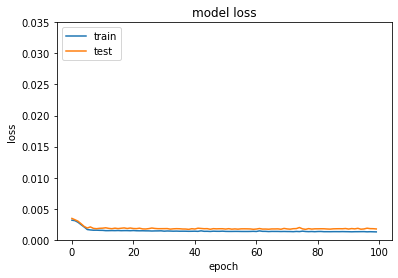

In [ ]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'test'], loc='upper left')
plt.ylim(ymin=0,ymax=0.035)
plt.show()

In [ ]:
train_predict=model.predict(X_train)
val_predict=model.predict(X_val)
test_predict=model.predict(X_test)

In [ ]:
train_predict=scaler.inverse_transform(train_predict)
val_predict=scaler.inverse_transform(val_predict)
test_predict=scaler.inverse_transform(test_predict)

In [ ]:
from sklearn.metrics import mean_squared_error
import math
math.sqrt(mean_squared_error(y_train,train_predict))

390.6611943340577

In [ ]:
math.sqrt(mean_squared_error(ytest,test_predict))

450.193566424357

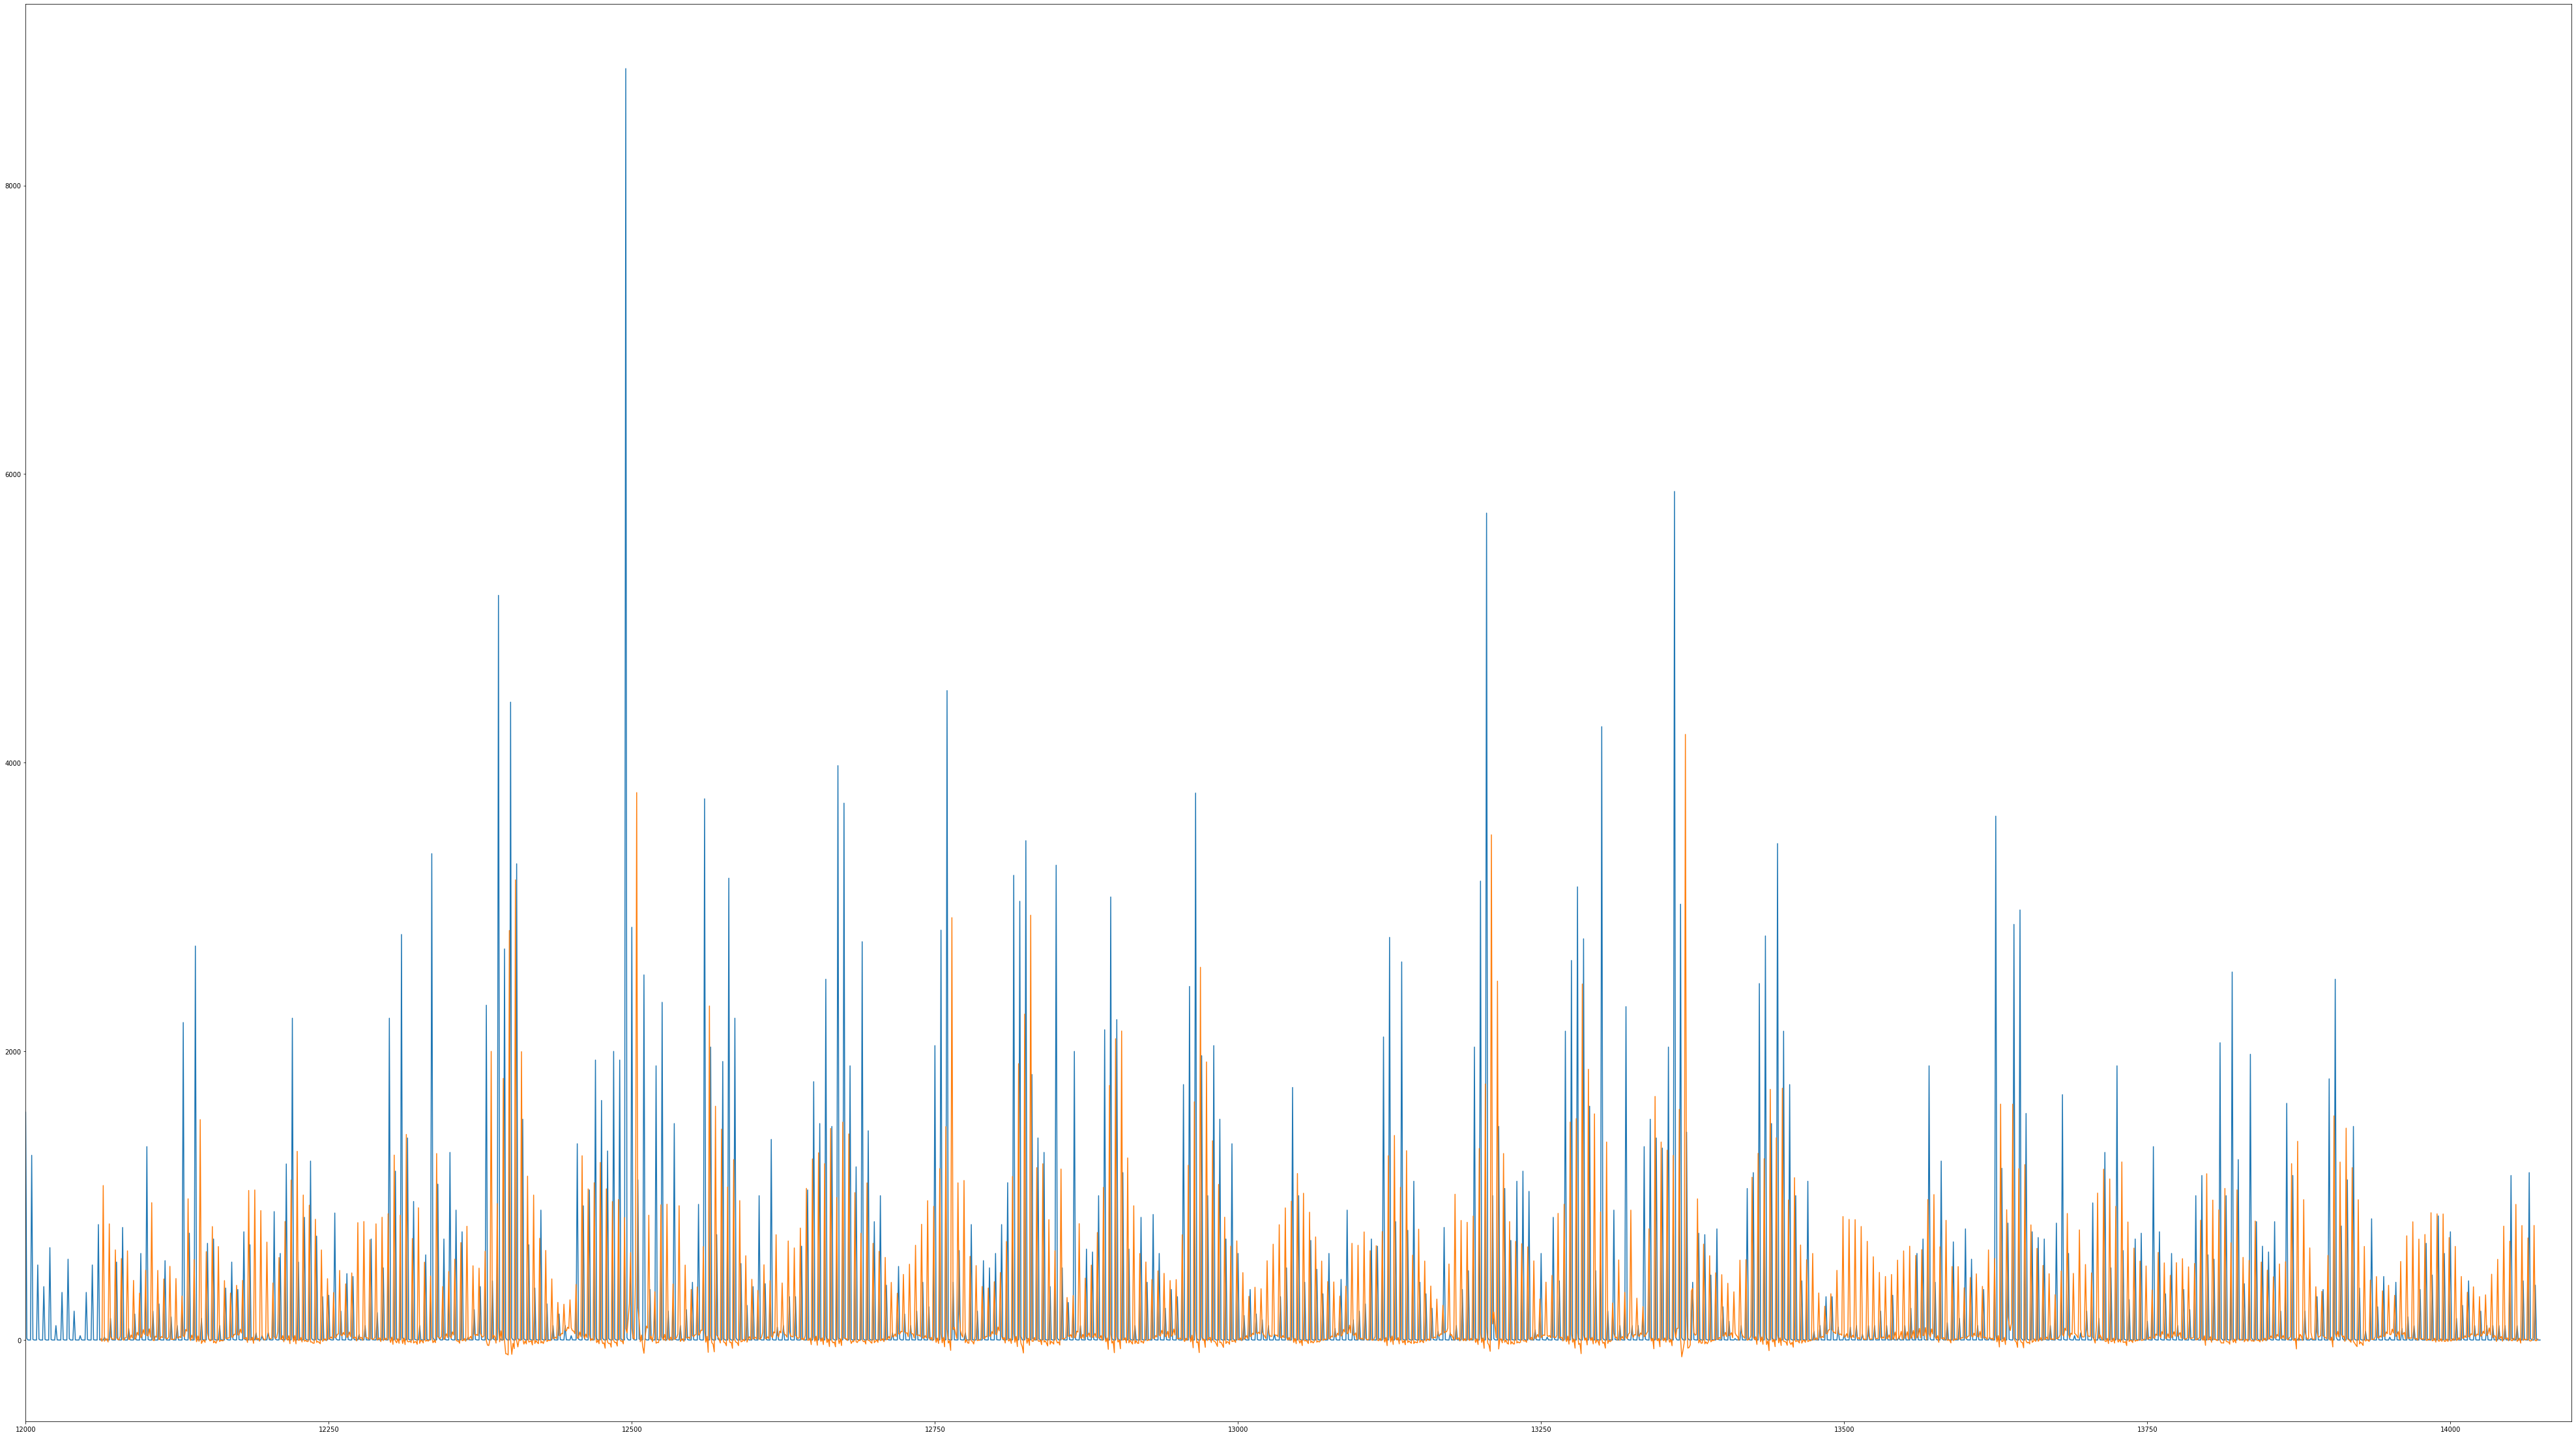

In [ ]:
look_back=100
trainPredictPlot = np.empty_like(df_sc)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
valPredictPlot = np.empty_like(df_sc)
valPredictPlot[:, :] = np.nan
valPredictPlot[len(train_predict)+(look_back*2)+1:len(train_predict)+len(val_predict)+(look_back*2)+1, :] = val_predict
testPredictPlot = np.empty_like(df_sc)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+len(val_predict)+(look_back*3)+1:len(df_sc)-2, :] = test_predict
fig = plt.figure()
 
fig.set_figheight(40)
fig.set_figwidth(70)
plt.plot(scaler.inverse_transform(df_sc))
#plt.plot(trainPredictPlot)
#plt.plot(valPredictPlot)
plt.xlim(12000,14100)
plt.plot(testPredictPlot)

plt.show()

